<a href="https://colab.research.google.com/github/jeremiah-toribio/ethy-prophet/blob/main/eth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [92]:
# yahoo finance
import yfinance as yf

# personal scripts
#import wrangle as w
# prophet model
from prophet import Prophet
from prophet.diagnostics import performance_metrics

# dataframes & matrices
import pandas as pd
import numpy as np

# stats and eval
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt

# viz
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# tsa split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid

# warnings
import warnings
warnings.filterwarnings("ignore")

# ignore cmdstanpy
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# for timing hyperparameter runing loop
from timeit import default_timer as timer
import time



In [2]:
# Personal for saving my data on to my Google Drive

# from google.colab import drive
# drive.mount('drive')

# Acquiring Eth-USD df

In [3]:
eth_usd = yf.Ticker("eth-usd")

In [4]:
pd.DataFrame([eth_usd.info]).T.reset_index()

,index,0
0,twitter,"""https://twitter.com/ethereum"""
1,name,Ethereum
2,startDate,1438905600
3,description,Ethereum (ETH) is a cryptocurrency . Ethereum ...
4,maxAge,86400
5,priceHint,2
6,previousClose,1613.7422
7,open,1613.7422
8,dayLow,1612.793
9,dayHigh,1649.1991


## <font color='red'>Prior to selecting **8 weeks** of data, **21 months** was used and price of ethereum has dramatically decreased to be able to get an accurate prediction for a 4 hour time mark </font>

### For concurrency and reproducibility;
<h3 style='background-color=DodgerBlue'> That the amount of data pulled would varie based on the volatility of the historical data </h3>

In [5]:
eth = eth_usd.history(period='8wk',interval='1h')

In [6]:
eth.to_csv('./eth.csv')
!cp eth.csv "drive/My Drive/"


cp: cannot create regular file 'drive/My Drive/': No such file or directory


# Preparing Eth

### These are wrangle.py functions dropped into colab for the sake of ease of use

In [7]:
def get_eth():
    '''
    Returns eth data that will be in csv format
    for not overdriving scraping.

    In order to cache data must run in Google Collab terminal
    ' !cp eth.csv "drive/My Drive/" '
    '''
    if os.path.isfile('eth.csv'):
        print('File exists, pulling from system.')
        eth = pd.read_csv('eth.csv')
        return eth
    else:
        print('File does not exist, extracting from Yahoo Finance.')

        eth = yf.Ticker("eth-usd")
        eth = eth.history(period='3mo',interval='1h')
        eth.to_csv('./eth.csv')
        return eth

def prepare_eth(eth):
    '''
    Cleans eth data to remove additional columns and organize
    data to be explored.
    '''
    # irrelevant stock columns
    eth = eth.drop(columns=['Dividends','Stock Splits'])
    # date information in columns
    eth['month'] = eth.index.month
    eth['year'] = eth.index.year
    eth['weekday'] = eth.index.dayofweek
    eth.columns = eth.columns.str.lower()
    eth['weekday'] = eth['weekday'].map({0:'Monday',1:'Tuesday',2:'Wednesday',
                        3:'Thursday',4:'Friday',5:'Saturday', 6:'Sunday'})
    eth['high_low_diff'] = eth.high - eth.low
    return eth


In [8]:
# preparing eth
eth = prepare_eth(eth)

# Exploring Eth

<Axes: xlabel='Datetime'>

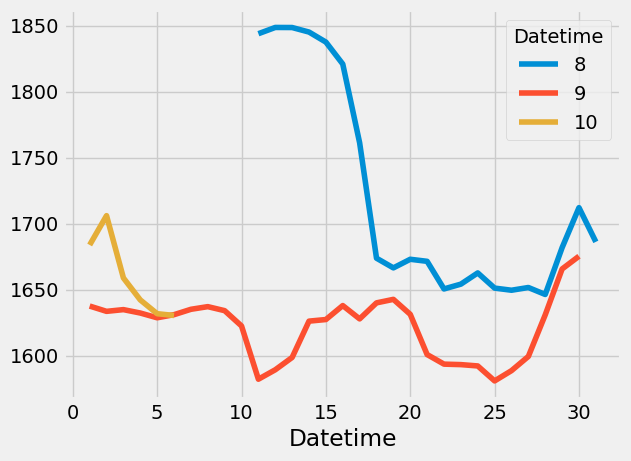

In [9]:
eth.groupby([eth.index.day,eth.index.month])['close'].mean().unstack().plot()

<Axes: xlabel='Datetime'>

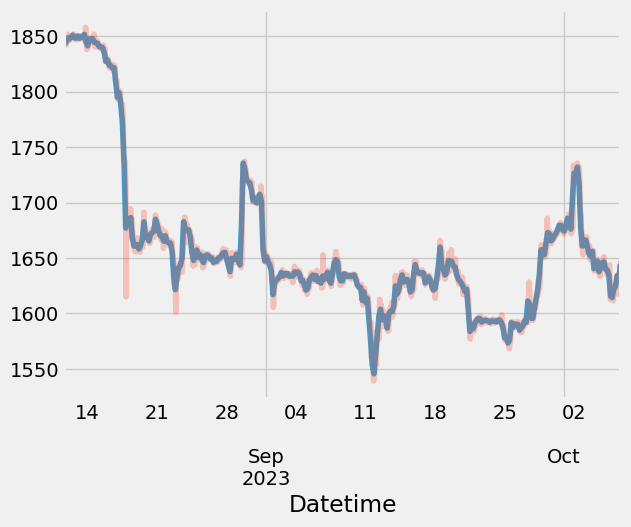

In [10]:
# comparing average resampled data for closing price
eth.close.resample('4h').mean().plot(alpha=.8)
eth.close.resample('1h').mean().plot(alpha=.3)

# Split

### Humanly determined
-- \
Using **92%** *train* and **8%** *test* \

<font color='blue'>This is determined since the price predicted is only on a 4-hour basis, a smaller test size would be better for a smaller time frame <font>

In [96]:
# getting train and test size
train_size = int(eth.shape[0] * .92)
test_size = int(eth.shape[0] * .08)

test_end_index = train_size + test_size


In [97]:
# slicing train & test
train = eth.close[:train_size]
test = eth.close[train_size:test_end_index]

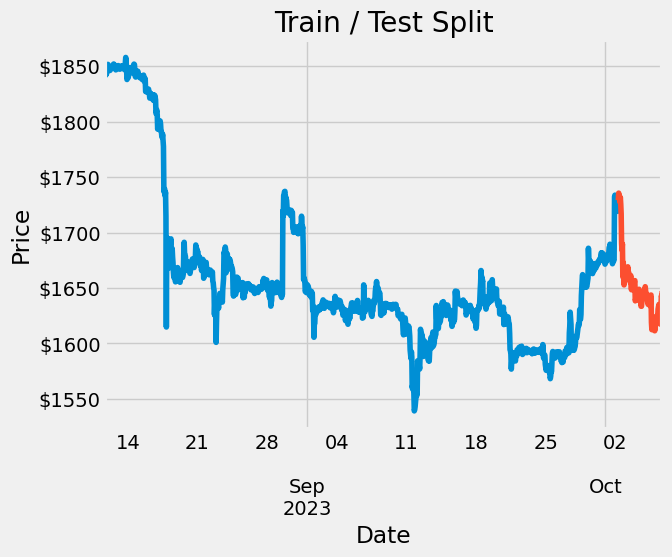

In [105]:
train.plot()
fig = test.plot()
fig.set_title('Train / Test Split')
fig.set_xlabel('Date')
fig.set_ylabel("Price")
fig.yaxis.set_major_formatter('${x:1.0f}')
plt.show()

In [13]:
# to visualize
print(f'Train shape: {train.shape}, Test shape: {test.shape} , Eth shape: {eth.shape}')

Train shape: (1237,), Test shape: (107,) , Eth shape: (1345, 9)


In [14]:
# in order to use the prophet model, must rename date as ds and target feature as y
train_model = train.reset_index()
train_model = train_model.rename(columns={'Datetime':'ds', 'close':'y'})
test_model = test.reset_index()
test_model = test_model.rename(columns={'Datetime':'ds', 'close':'y'})

In [15]:
# Setting ds as datetime
train_model.ds = train_model.ds.astype('datetime64[ns]')
test_model.ds = test_model.ds.astype('datetime64[ns]')
train_model_fit = train_model.copy()

## Split using SKLearn (Did not use)

In [16]:
# dtscv = TimeSeriesSplit(n_splits=3)

In [17]:
# for train_index, test_index in tscv.split(X):

#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Finding Baselines
### This is exclusive to test baselines
  - Last Observed Value
  - Simple Average
  - Moving Average

In [18]:
def metrics_dataframe(model,RMSE):
    '''
    Keep track and automatically append data to compare models.
    '''
    metrics_df = pd.DataFrame(data=[
            {
                'model':model,
                'rmse':RMSE
            }
            ])
    return metrics_df

def save_metrics(df, model, RMSE):
    '''
    Used to automatically save metrics data on to a dataframe, would not allow for
    duplicate model names to be saved
    '''

    df.loc[len(df)] = [model, RMSE]
    df = df[~df.duplicated('model')]
    return df

## Last Observed

In [74]:
def yhat(col, value, df):
    '''
    Used to save baseline calculated scores, as the same length as test_model.
    '''
    yhat_df = pd.DataFrame(
    {col: [value]},
    index=df.ds)

    # to be able to plot baseline yhat and eth together
    yhat_df.merge(df, on=df.ds, how='left')
    return yhat_df

In [76]:
# last item in close
last_close = train[-1:][0]

yhat_df = yhat(col='close',value=last_close, df=test_model)
yhat_df

,close
ds,
2023-10-02 07:00:00,1723.644165
2023-10-02 08:00:00,1723.644165
2023-10-02 09:00:00,1723.644165
2023-10-02 10:00:00,1723.644165
2023-10-02 11:00:00,1723.644165
...,...
2023-10-06 13:00:00,1723.644165
2023-10-06 14:00:00,1723.644165
2023-10-06 15:00:00,1723.644165


<Axes: xlabel='Datetime'>

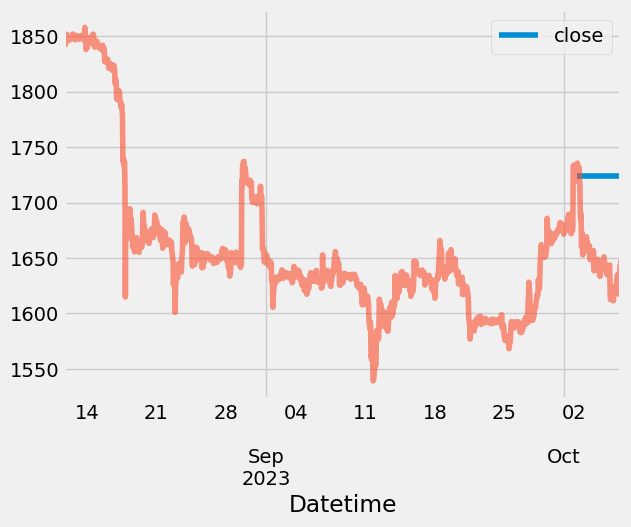

In [79]:
# Last Observed Baseline Visualized
yhat_df.plot()
eth.close.resample('1h').mean().plot(alpha=.6)

In [80]:
# calculating RMSE for baselines
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df.close))

In [81]:
# saving baseline scores on to metrics_df
metrics_df = metrics_dataframe(model = 'last-observed' ,RMSE=score)

In [82]:
metrics_df

,model,rmse
0,last-observed,78.234695


## Simple Average

In [83]:
# last item in close
close_avg = train.mean()

yhat_df = yhat(col='simple-avg',value=close_avg, df = test_model)

<Axes: xlabel='Datetime'>

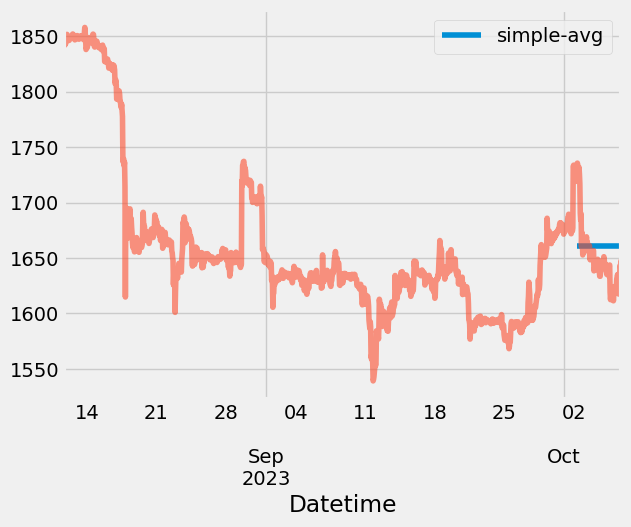

In [86]:
# Simple Average Baseline Visualized
yhat_df.plot()
eth.close.resample('1h').mean().plot(alpha=.6)

In [84]:
# calculating RMSE for baselines
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df['simple-avg']))

In [85]:
# saving baseline scores on to metrics_df
save_metrics(df=metrics_df,model='simple-avg', RMSE=score)

,model,rmse
0,last-observed,78.234695
1,simple-avg,29.382369


## Moving Average

In [88]:
period = 4

# last item in close
rolling = round(train.rolling(period).mean()[-1], 2)

yhat_df = yhat(col='rolling',value=rolling, df = test_model)

In [89]:
# calculating RMSE for baselines
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= yhat_df['rolling']))

<Axes: xlabel='Datetime'>

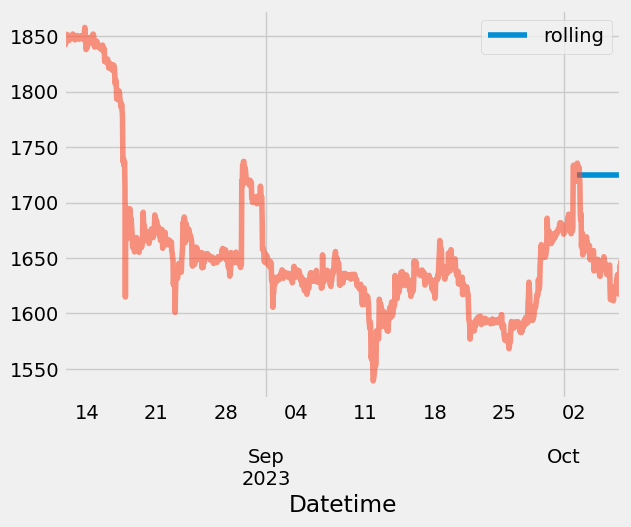

In [90]:
yhat_df.plot()
eth.close.resample('1h').mean().plot(alpha=.6)

In [29]:
# saving baseline scores on to metrics_df
save_metrics(df=metrics_df, model = 'moving-avg-4hr',RMSE=score)

,model,rmse
0,last-observed,78.234695
1,simple-avg,29.382369
2,moving-avg-4hr,79.158195


# Parameter Tuning

## Holidays (not used)

In [30]:
# importing US holidays for model date identification

import holidays

holiday = pd.DataFrame([])
for date, name in sorted(holidays.UnitedStates(years=[2023]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "US-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

## Parameter Grid

In [31]:
# creating a parameter grid to test a variety of parameters to tune model to best
# fit needs
p_grid = {
          'seasonality_mode':('multiplicative','additive'),
          'seasonality_prior_scale':[0.01,0.1,1,5],
          'changepoint_prior_scale':[0.1,0.2,0.5],
          'changepoint_range':[0.65,0.70,0.75,0.80,0.85]
          }

grid = ParameterGrid(p_grid)

its = 0
for p in grid:
  its = its+1

print(f'Total number of models: {its}')

Total number of models: 120


In [32]:
# dataframe object to save all created models from loop
model_parameters = pd.DataFrame(columns = ['MAPE','RMSE','Parameters'])
i = 0
total_time = 0
for x in grid:
    # timing iterations to understand how long to expect to re-run models
    start = timer()
    test = pd.DataFrame()
    i += 1
    print(f'Num of Iteration: {i} of {its}')
    print(x)
    np.random.seed(4343)
    # model object created
    train_model_loop =Prophet(
                         changepoint_prior_scale = x['changepoint_prior_scale'],
                         seasonality_prior_scale = x['seasonality_prior_scale'],
                         seasonality_mode = x['seasonality_mode'],
                         weekly_seasonality= True,
                         daily_seasonality = True,
                         yearly_seasonality= False,
                         #holidays=holiday,
                         interval_width=0.95)
    # train_model_loop.add_country_holidays(country_name='US')

    # Removed holidays due to the low factor of importance for cryptocurrency trading, this resulted in
    # marginal increases to accuracy. This could be turned on again if looking at yearly data.

    # Fit to predict 4 hourly periods
    train_model_loop.fit(train_model)
    train_forecast = train_model_loop.make_future_dataframe(periods=4, freq='H',include_history = False)
    train_forecast = train_model_loop.predict(train_forecast)
    pred=train_forecast[['ds','yhat']]
    MAPE = mean_absolute_percentage_error(train_model.y.tail(4),abs(pred[['yhat']]))
    RMSE = sqrt(mean_squared_error(train_model.y.tail(4),abs(pred[['yhat']])))
    print('Mean Absolute Percentage Error(MAPE): +++++++',round(MAPE * 100, 4) )
    print('Root Mean Squared Error(RMSE): +++++++',round(RMSE, 4) )
    end = timer()
    runtime = round(end - start, 2)
    total_time += runtime
    print(f'Time (SECONDS): {runtime}, Total time (SECONDS): {round(total_time, 2)}, Total time (MINUTES): {round(total_time / 60, 2)} ')
    model_parameters = model_parameters.append({'MAPE':round(MAPE * 100, 2),'RMSE':round(RMSE, 2),'Parameters':x},ignore_index=True)


Num of Iteration: 1 of 120
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}
Mean Absolute Percentage Error(MAPE): +++++++ 2.9938
Root Mean Squared Error(RMSE): +++++++ 51.7464
Time (SECONDS): 2.18, Total time (SECONDS): 2.18, Total time (MINUTES): 0.04 
Num of Iteration: 2 of 120
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}
Mean Absolute Percentage Error(MAPE): +++++++ 2.9911
Root Mean Squared Error(RMSE): +++++++ 51.6985
Time (SECONDS): 1.81, Total time (SECONDS): 3.99, Total time (MINUTES): 0.07 
Num of Iteration: 3 of 120
{'changepoint_prior_scale': 0.1, 'changepoint_range': 0.65, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1}
Mean Absolute Percentage Error(MAPE): +++++++ 2.9937
Root Mean Squared Error(RMSE): +++++++ 51.7437
Time (SECONDS): 2.21, Total time (SECONDS): 6.2, Total time (MINUTES): 0.1

In [33]:
# if deciding to run loop again, keep previous results
saved_params = model_parameters.copy()

In [34]:
# view parameters truncated in dataframe
pd.set_option('display.max_colwidth', None)

In [35]:
# sort values by MAPE
saved_params.sort_values('MAPE',ascending=True,inplace=True)

In [36]:
# exporting hyperparams as csv to save data
saved_params.to_csv('hyperparams.csv')

# Parameter Analysis on Train

Although the range of scores is not far off, parameters that are consistency performing ***better*** are:
- **'changepoint_prior_scale'** of **0.1**
- **'seasonality_mode'** of **'multiplicative'**

Other parameters did not have consistent results



In [37]:
# although there were usually multiple sets of parameters that had the same score, just take the top one
best_params = saved_params.Parameters.loc[0]

In [38]:
best_params

{'changepoint_prior_scale': 0.1,
 'changepoint_range': 0.65,
 'seasonality_mode': 'multiplicative',
 'seasonality_prior_scale': 0.01}

# Creating Model with Discovered Parameters

In [39]:
# uses top selection from used grid -- although numerous with same score, just top 1 is used
m = Prophet(**best_params,
            weekly_seasonality= True,
            daily_seasonality = True,
            yearly_seasonality= False,
            interval_width=0.95)

In [40]:
# fit best params model
model = m.fit(train_model_fit)

# Test predicted

In [41]:
# predict on test
testmodel_forecast = model.predict(test_model)

## Forecast is created with train set -- it will return yhat and lots of other information that can be used to analyze results further

In [42]:
# get prophet training results, forecast will show accuracy on training set
future = model.make_future_dataframe(periods=4, freq='H')
forecast = model.predict(future)

## Exploring Forecast for train and test

In [43]:
# forecast is a dataframe that will contain 40 columns of metric data, we will
# only look at these 5 for now
forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-08-11 18:00:00,1838.783974,0.000767,-0.000430,1839.404410
1,2023-08-11 19:00:00,1838.918650,0.000896,-0.000926,1838.862843
2,2023-08-11 20:00:00,1839.053325,0.001031,-0.001269,1838.615458
3,2023-08-11 21:00:00,1839.188001,0.001173,-0.001181,1839.173512
4,2023-08-11 22:00:00,1839.322677,0.001321,-0.000687,1840.488663
...,...,...,...,...,...
1236,2023-10-02 06:00:00,1639.554895,0.000524,0.000471,1641.186355
1237,2023-10-02 07:00:00,1639.623082,0.000090,0.000259,1640.194628
1238,2023-10-02 08:00:00,1639.691269,-0.000349,0.000076,1639.244049
1239,2023-10-02 09:00:00,1639.759457,-0.000790,0.000142,1638.697474


<div style="background-color: #A9CCE3; box-shadow: 0 0 0 1px black; padding: 5px;">
NOTE: We can see that the end of forecast will lead right into the beginning of testmodel_forecast
</div>


In [44]:
testmodel_forecast[['ds','trend','weekly','daily','yhat']]

,ds,trend,weekly,daily,yhat
0,2023-10-02 07:00:00,1639.623082,0.000090,0.000259,1640.194628
1,2023-10-02 08:00:00,1639.691269,-0.000349,0.000076,1639.244049
2,2023-10-02 09:00:00,1639.759457,-0.000790,0.000142,1638.697474
3,2023-10-02 10:00:00,1639.827644,-0.001231,0.000437,1638.526714
4,2023-10-02 11:00:00,1639.895831,-0.001670,0.000711,1638.322736
...,...,...,...,...,...
102,2023-10-06 13:00:00,1646.578177,0.000235,0.000448,1647.702572
103,2023-10-06 14:00:00,1646.646365,0.000326,0.000128,1647.393873
104,2023-10-06 15:00:00,1646.714552,0.000425,-0.000026,1647.371201
105,2023-10-06 16:00:00,1646.782739,0.000532,-0.000028,1647.611724


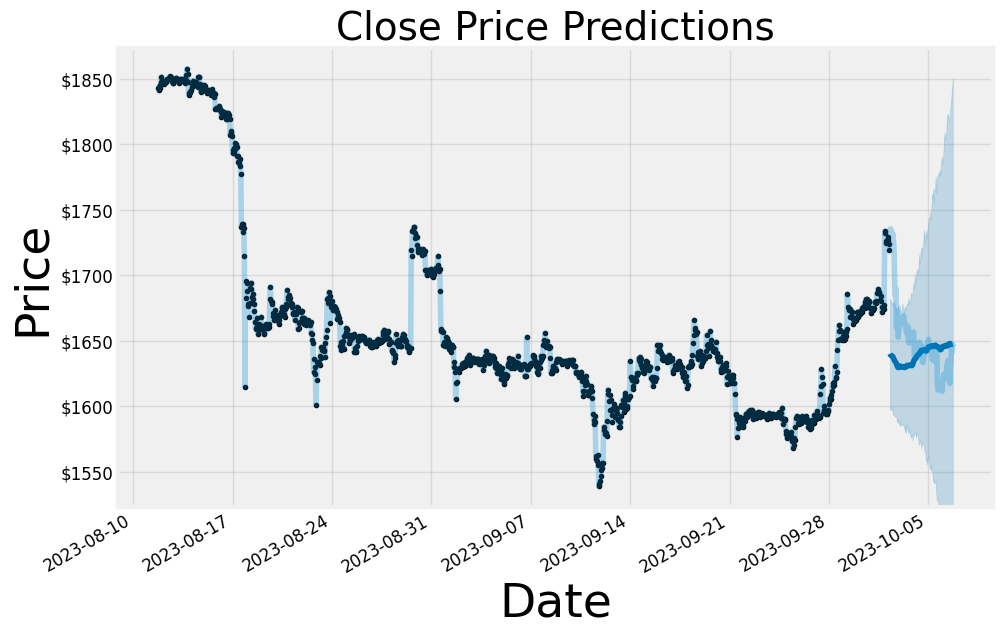

In [45]:
# Adjusting visualization for presentation
fig = model.plot(testmodel_forecast)
ax = fig.gca()
ax.set_title("Close Price Predictions", size=28)
ax.set_xlabel("Date", size=34)
ax.set_ylabel("Price", size=34)
ax.yaxis.set_major_formatter('${x:1.0f}')
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)

fig2 = eth.close.plot(alpha=.3)
fig2.set_xlabel("Date", size=34)
plt.show()

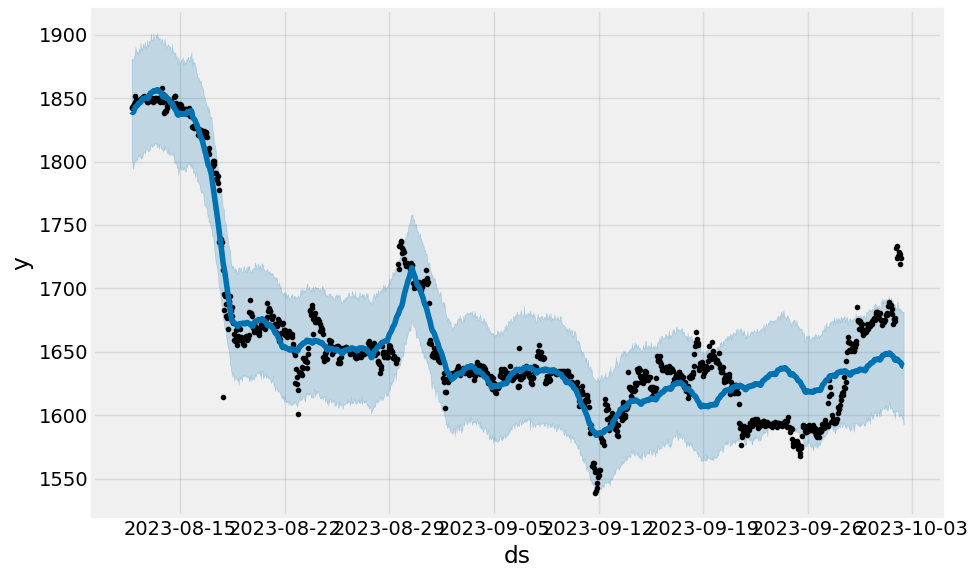

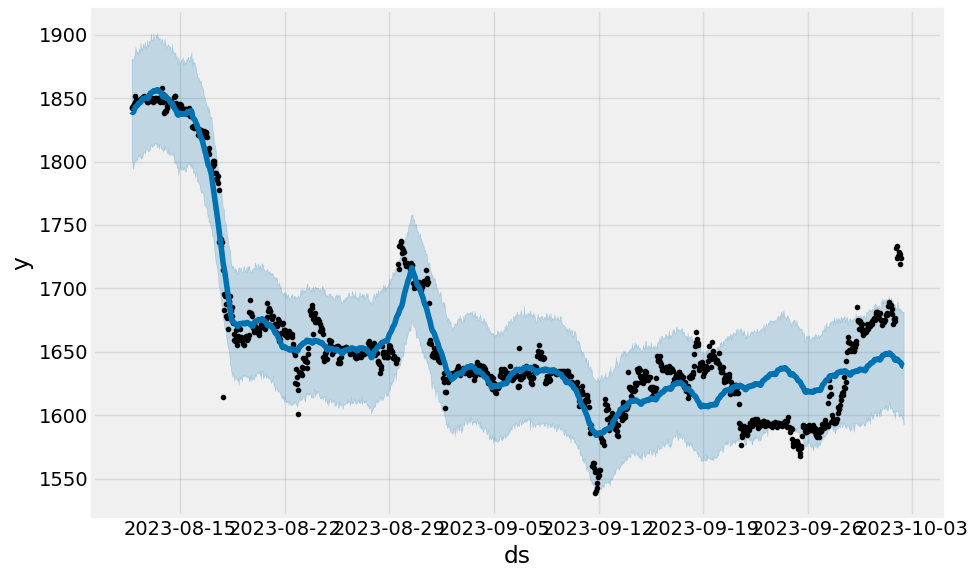

In [46]:
# train on top of actual
m.plot(forecast)

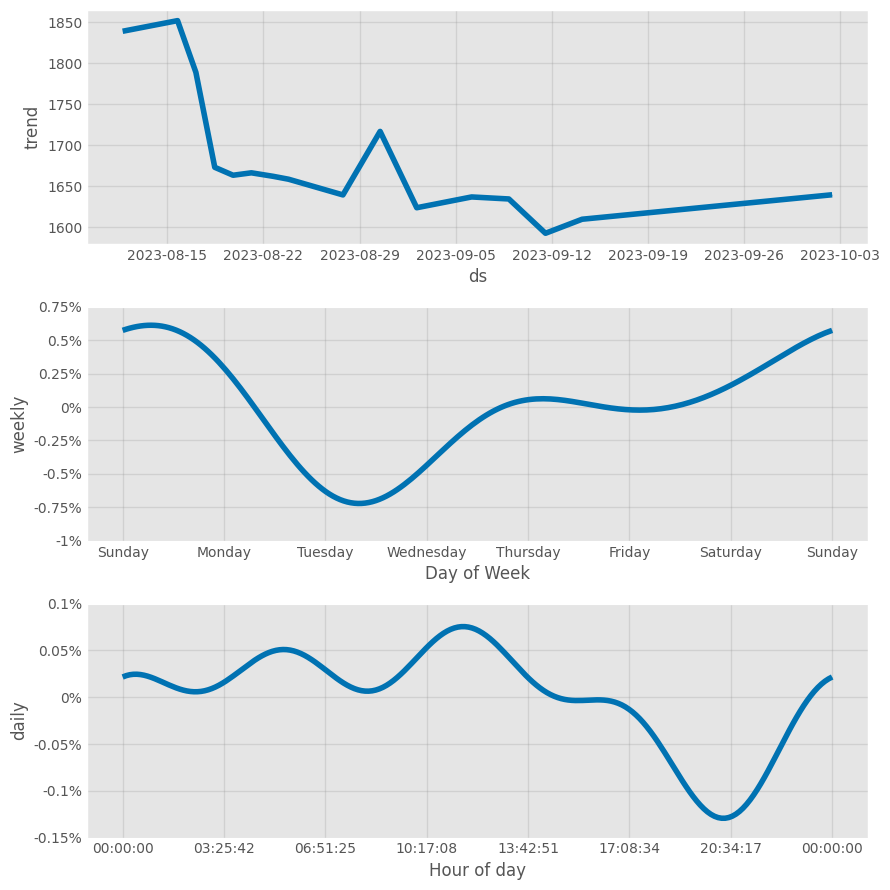

In [47]:
# train components give lots of insight into trend, weekly and daily data
with plt.style.context('ggplot'):
  m.plot_components(forecast)

In [48]:
# Metrics for LAST 4 PREDICTIONS ONLY. NOT ACCURATE TO MAPE OR RMSE, FOR LEARNING PURPOSES ONLY.
pred=testmodel_forecast[['ds','yhat']]
MAPE = mean_absolute_percentage_error(test_model.y.tail(4),abs(pred[['yhat']].tail(4)))
RMSE = sqrt(mean_squared_error(test_model.y.tail(4),abs(pred[['yhat']]).tail(4)))
print('Mean Absolute Percentage Error(MAPE): ',round(MAPE * 100, 4) )
print('Root Mean Squared Error(RMSE): ',round(RMSE, 4) )

Mean Absolute Percentage Error(MAPE):  0.376
Root Mean Squared Error(RMSE):  7.7833


In [49]:
# Test Metrics
pred=testmodel_forecast[['ds','yhat']]
MAPE = mean_absolute_percentage_error(test_model.y,abs(pred[['yhat']]))
RMSE = sqrt(mean_squared_error(test_model.y,abs(pred[['yhat']])))
print('Mean Absolute Percentage Error(MAPE): ',round(MAPE * 100, 4) )
print('Root Mean Squared Error(RMSE): ',round(RMSE, 4) )

Mean Absolute Percentage Error(MAPE):  1.3982
Root Mean Squared Error(RMSE):  32.9783


In [50]:
# Saving test metrics
score = sqrt(mean_squared_error(y_true=test_model.y ,y_pred= pred.yhat))

save_metrics(df=metrics_df, model = 'best_params',RMSE=score)

,model,rmse
0,last-observed,78.234695
1,simple-avg,29.382369
2,moving-avg-4hr,79.158195
3,best_params,32.978328


In [51]:
labels = metrics_df.sort_values('rmse')

# Model Results


In [ ]:
# Implimenting cross validatation
# cutoffs = ['']

In [ ]:

# best_params = performance_metrics(testmodel_forecast)
# best_params.head()

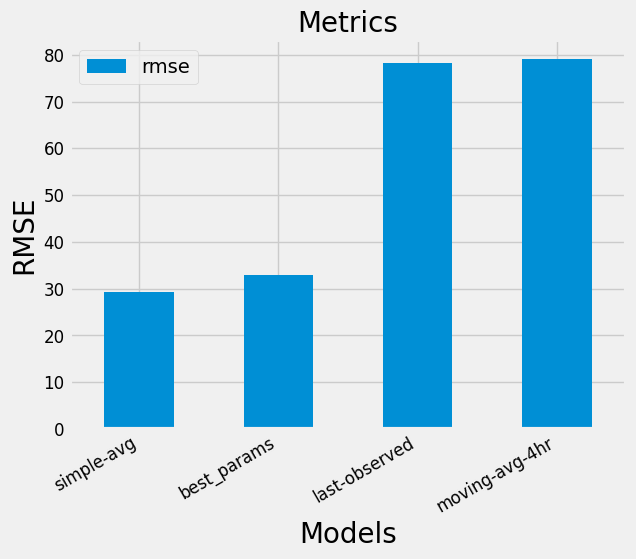

In [52]:
fig1 = metrics_df.sort_values('rmse').plot(kind='bar', x='model')
fig1.set_title('Metrics', size = 20)
fig1.set_xlabel('Models', size=20)
fig1.set_ylabel("RMSE", size=20)
fig1.tick_params(axis="x", labelsize=12)
fig1.tick_params(axis="y", labelsize=12)
fig1.set_xticklabels(labels = labels.model,rotation=30, ha='right')
plt.show()

In [53]:
metrics_df

,model,rmse
0,last-observed,78.234695
1,simple-avg,29.382369
2,moving-avg-4hr,79.158195
3,best_params,32.978328


# Conclusion

- There is a lot of potential to be able to predict on Ethereum prices accurately, but understanding that price is also a quasi-schotastic metric for a human determined value.

- In performance, model was able to beat baselines but ultimately not ready for actionable use.

- The best results came from shrinking the range of price, the model performed better at not placing prediction points closer to actual.

- The trend information prophet provides would be the most actionable, and this may also be misleading as one day out of the week may have seen a much larger volume (*for one reason or another*) therefore having a greater impact on price.

- The values of time and split are not static in this notebook as they will be tuned for testing and results of project will always vary.

# Next Steps

- Add cross validation
- Be able to find the closest range of price to decide what to train off of automatically
- Gain further insights using Prophet diagnostics
- ????
- Profit